[Ссылка на профиль Kaggle.com](https://www.kaggle.com/romanmirrus)


## **Курсовой проект**

### **Постановка задачи**

**Задача**  
Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**  
*course_project_train.csv* - обучающий датасет  
*course_project_test.csv* - тестовый датасет  
**Целевая переменная**  
*Credit Default* - факт невыполнения кредитных обязательств  
**Метрика качества**  
*F1-score* (sklearn.metrics.f1_score)

### **Обзор данных**

**Описание датасета**  
* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - баллы кредитного рейтинга
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [1]:
!pip install imblearn
!pip install xgboost
!pip install lightgbm
!pip install catboost

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import re

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
import xgboost as xgb, lightgbm as lgbm, catboost as catb

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
DATA_TRAIN_PATH = '/content/drive/MyDrive/Colab Notebooks/gb_2/course_project_train.csv'
DATA_TEST_PATH = '/content/drive/MyDrive/Colab Notebooks/gb_2/course_project_test.csv'

In [4]:
data_train = pd.read_csv(DATA_TRAIN_PATH)
data_test = pd.read_csv(DATA_TEST_PATH)
target = 'Credit Default'
data_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


Посмотрим на размерность наборов данных, какими типами данных представлены признаки и целевая переменная в этих наборах, а также проверим наличие пропусков.

In [5]:
for df in [data_train, data_test]:
    set_name = 'data_train' if target in df.columns else 'data_test'
    print('-' * 75)
    print(f"Количество строк в {set_name} равно {df.shape[0]}")
    print(f"Количество столбцов в {set_name} равно {df.shape[1]}")
    print(f"Данные в {set_name} представлены следующими типами:", df.dtypes.value_counts(), sep='\n')
    print(f"Количество дублирующих записей в {set_name} равно {df[df.duplicated()].size}")
    for col in df.columns:
        val_miss = df.loc[df[col].isnull()].shape[0]
        if val_miss > 0:
            print(
                f"Количество пропусков признака {col} в {set_name} равно {val_miss} ({round((val_miss/df.shape[0])*100, 2)} %)"
                )

---------------------------------------------------------------------------
Количество строк в data_train равно 7500
Количество столбцов в data_train равно 17
Данные в data_train представлены следующими типами:
float64    12
object      4
int64       1
dtype: int64
Количество дублирующих записей в data_train равно 0
Количество пропусков признака Annual Income в data_train равно 1557 (20.76 %)
Количество пропусков признака Years in current job в data_train равно 371 (4.95 %)
Количество пропусков признака Months since last delinquent в data_train равно 4081 (54.41 %)
Количество пропусков признака Bankruptcies в data_train равно 14 (0.19 %)
Количество пропусков признака Credit Score в data_train равно 1557 (20.76 %)
---------------------------------------------------------------------------
Количество строк в data_test равно 2500
Количество столбцов в data_test равно 16
Данные в data_test представлены следующими типами:
float64    12
object      4
dtype: int64
Количество дублирующих запис

Для оптимизации памяти, которую занимают наборы данных, используем функции *optimize_int_col*, *optimize_float_col* и *optimize_memory*.

In [6]:
def optimize_int_col(df, col):
    '''
    Optimization of the memory used by int type data set's columns
    '''
    col_min = df[col].min()
    col_max = df[col].max()
    if col_min < 0:
        if col_min >= np.iinfo(np.int8).min and col_max <= np.iinfo(np.int8).max:
            df[col] = df[col].astype(np.int8)
        elif col_min >= np.iinfo(np.int16).min and col_max <= np.iinfo(np.int16).max:
            df[col] = df[col].astype(np.int16)
        elif col_min >= np.iinfo(np.int32).min and col_max <= np.iinfo(np.int32).max:
            df[col] = df[col].astype(np.int32)
    else:
        if col_min >= 0 and col_max <= np.iinfo(np.uint8).max:
            df[col] = df[col].astype(np.uint8)
        elif col_min >= 0 and col_max <= np.iinfo(np.uint16).max:
            df[col] = df[col].astype(np.uint16)
        elif col_min >= 0 and col_max <= np.iinfo(np.uint32).max:
            df[col] = df[col].astype(np.uint32)  

def optimize_float_col(df, col):
    '''
    Optimization of the memory used by float type data set's columns
    '''
    col_min = df[col].min()
    col_max = df[col].max()
    if df.loc[df[col] % 1 > 0].shape[0] > 0 or df.loc[df[col].isnull()].shape[0] > 0:
        if col_min >= np.finfo(np.float16).min and col_max <= np.finfo(np.float16).max:
            df[col] = df[col].astype(np.float16)
        elif col_min >= np.finfo(np.float32).min and col_max <= np.finfo(np.float32).max:
            df[col] = df[col].astype(np.float32)
    else:
        optimize_int_col(df, col)

def optimize_memory(df):
    '''
    Optimization of the memory used by the dataset
    '''
    if isinstance(df, pd.DataFrame):
        set_name = 'data_train' if target in df.columns else 'data_test'
        start_mem = df.memory_usage().sum() / 1024 ** 2
        print('Memory usage of {} is {:.2f} MB'.format(set_name, start_mem))
        for col in df.columns:
            col_type = str(df[col].dtype)
            if 'int' in col_type:
                optimize_int_col(df, col)
            elif 'float' in col_type:
                optimize_float_col(df, col)
            elif 'object' in col_type:
                df[col] = df[col].astype('category')

        end_mem = df.memory_usage().sum() / 1024**2
        print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    else:
        print('В качестве аргумента необходимо передать pd.DataFrame()')

In [7]:
for df in [data_train, data_test]:
    optimize_memory(df)

print(f"\nПосле оптимизации данные представлены следующими типами:", data_train.dtypes, sep='\n')

Memory usage of data_train is 0.97 MB
Memory usage after optimization is: 0.26 MB
Decreased by 73.4%
Memory usage of data_test is 0.31 MB
Memory usage after optimization is: 0.08 MB
Decreased by 72.2%

После оптимизации данные представлены следующими типами:
Home Ownership                  category
Annual Income                    float32
Years in current job            category
Tax Liens                          uint8
Number of Open Accounts            uint8
Years of Credit History          float16
Maximum Open Credit               uint32
Number of Credit Problems          uint8
Months since last delinquent     float16
Bankruptcies                     float16
Purpose                         category
Term                            category
Current Loan Amount               uint32
Current Credit Balance            uint32
Monthly Debt                      uint32
Credit Score                     float16
Credit Default                     uint8
dtype: object


Разобъем данные тренировочного набора по признакам  и целевой переменной на две выборки: <code>X_train</code> и <code>X_test</code>, <code>y_train</code> и <code>y_test</code>.

In [8]:
y = data_train[target]
X = data_train.drop([target], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=21, shuffle=True)
df_dict = {'X_train': X_train, 'X_test': X_test, 'data_test': data_test}

In [9]:
y.value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

В тренировочном наборе у значений целевой переменной наблюдается дисбаланс классов.

### **Обработка признаков**

Для построения гистограмм будем использовать функцию *get_hist*.

In [10]:
def get_hist(df, fl, bins=20, yscale=None):
    '''Draw histograms for data set's features from list, max columns equals 3'''

    if len(fl) % 3 == 0:
        rows, cols = (len(fl) // 3, 3)
    elif len(fl) < 3:
        rows, cols = (1, len(fl) % 3)
    else:
        rows, cols = (len(fl) // 3 + 1, 3)
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols * 5, rows * 4))
    if cols == 1:
        axes = np.array(axes)
    for ax, f in zip(axes.reshape(-1), fl):
        ax.hist(df[f], bins=bins, edgecolor='white')
        ax.set_title(f)
        if yscale == 'log':
            ax.set_yscale('log')
    plt.show()

**Признак Purpose**   

In [11]:
X_train['Purpose'].value_counts()

debt consolidation      3992
other                    445
home improvements        281
business loan             86
buy a car                 61
medical bills             47
take a trip               22
major purchase            22
buy house                 21
small business            18
wedding                   11
educational expenses       7
moving                     6
vacation                   5
renewable energy           1
Name: Purpose, dtype: int64

Рассмотрим на какие категории по цели кредитования делятся записи в наборах данных:
* business loan	- бизнес-кредит
* buy a car	- кредит на покупку автомобиля
* buy house	- кредит на покупку дома
* debt consolidation - кредит на обслуживание уже имеющегося долга
* educational expenses - кредит на образование
* home improvements	- кредит на улучшения в доме
* major purchase - кредит на крупную покупку
* medical bills	- кредит на медицинские услуги 
* moving - кредит на переезд
* other	- кредит на другие нужды
* renewable energy - кредит на возобновляемые источники энергии
* small business - кредит для малого бизнеса
* take a trip	- кредит для путешествия
* vacation - кредит на отпуск	
* wedding	- кредит на свадьбу

Создадим новый признак на основе признака *Purpose* - посчитаем вес каждого значения в наборе *X_train*, а затем полученные значения применим к наборам *X_test* и *data_test*.

In [12]:
def get_feature_weight(df, feature, base_df):
    feature_weight = base_df[feature].value_counts() / base_df.shape[0]
    df[f'{feature}_weight'] = 0
    for i in feature_weight.index:
        df.loc[df[feature] == i, f'{feature}_weight'] = feature_weight.loc[i]

for df in df_dict.values():
    get_feature_weight(df, 'Purpose', X_train)

**Признак Years of Credit History**  
Построим гистограмму распределения значений данного признака.

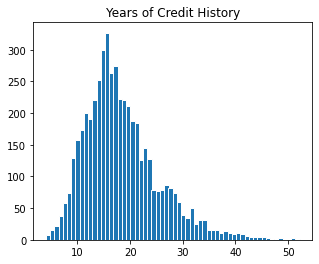

In [13]:
get_hist(X_train, ['Years of Credit History'], bins=60)

Форма распределения значений признака похожа на нормальное распределение, имеется длинный правый хвост. Проверим значения на выбросы, построив *boxplot* с разбивкой по признаку *Purpose*.

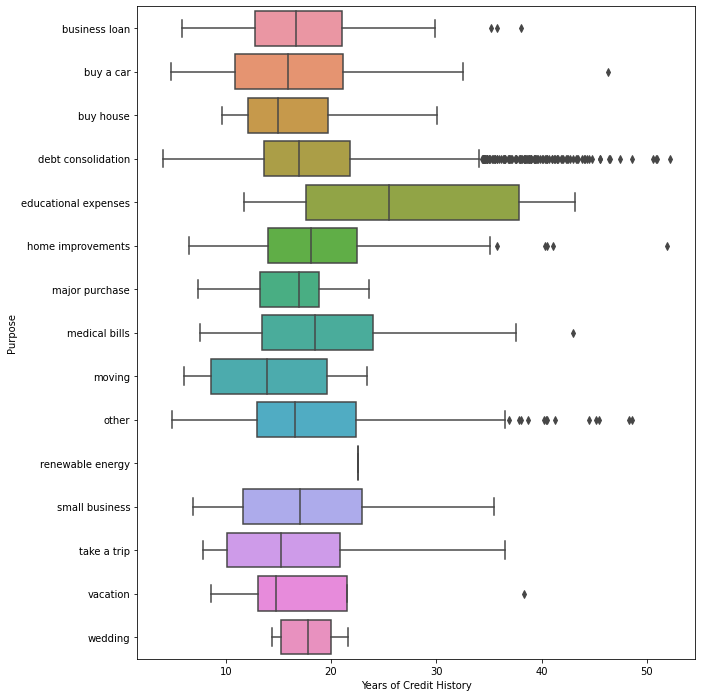

In [14]:
fig, ax = plt.subplots(figsize=(10, 12))
ax = sns.boxplot(x='Years of Credit History',
            y='Purpose', 
            data=X_train)
plt.show()

В тех категориях признака *Purpose*, где имеется достаточно значений (больше 20), найдем границы при помощи межквартильного расстояния.

In [15]:
def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

purpose_counts = X_train['Purpose'].value_counts().reset_index()
purpose_counts.columns = ['Purpose', 'Purpose_count']
purposes = purpose_counts.loc[purpose_counts['Purpose_count'] > 20, 'Purpose']

# находим значения min, quartile-25, quartile-75, max для значений признака Purpose из списка purposes
year_bounds = X_train.loc[X_train['Purpose'].isin(purposes), ['Purpose', 'Years of Credit History']]\
    .groupby('Purpose').agg({'Years of Credit History': [min, q25, q75, max]}).dropna()
# находим интерквартильный размах
year_bounds['iqr'] = year_bounds.loc[:, ('Years of Credit History', 'q75')] - year_bounds.loc[:, ('Years of Credit History', 'q25')]
# находим нижнюю границу, если ее величина меньше минимального значения, то заменяем lower_bound на min
year_bounds['left_bound'] = year_bounds.loc[:, ('Years of Credit History', 'q25')] - year_bounds['iqr'] * 1.5
year_bounds.loc[year_bounds['left_bound'] < year_bounds[('Years of Credit History', 'min')], 'left_bound']\
    = year_bounds.loc[year_bounds['left_bound'] < year_bounds[('Years of Credit History', 'min')], ('Years of Credit History', 'min')]
# находим верхнюю границу, если ее величина больше максимального значения, то заменяем upper_bound на max
year_bounds['right_bound'] = year_bounds.loc[:, ('Years of Credit History', 'q75')] + year_bounds['iqr'] * 1.5
year_bounds.loc[year_bounds['right_bound'] > year_bounds[('Years of Credit History', 'max')], 'right_bound']\
    = year_bounds.loc[year_bounds['right_bound'] > year_bounds[('Years of Credit History', 'max')], ('Years of Credit History', 'max')]
year_bounds

Years of Credit History             ... left_bound right_bound
                                       min        q25  ...                       
Purpose                                                ...                       
business loan                     5.800781  12.796875  ...   5.800781    33.46875
buy a car                         4.800781  10.898438  ...   4.800781    36.37500
buy house                         9.601562  12.101562  ...   9.601562    30.09375
debt consolidation                4.000000  13.601562  ...   4.000000    34.09375
home improvements                 6.500000  14.000000  ...   6.500000    35.25000
major purchase                    7.398438  13.296875  ...   7.398438    23.59375
medical bills                     7.601562  13.406250  ...   7.601562    39.78125
other                             4.898438  13.000000  ...   4.898438    36.50000
take a trip                       7.800781  10.125000  ...   7.800781    36.50000

[9 rows x 7 columns]

Заменим выбросы значений признака *Years of Credit History* на медианы данного признака, сгруппированные по признаку *Purpose*.

In [16]:
year_medians = X_train[['Purpose', 'Years of Credit History']].groupby('Purpose').median()

for df in df_dict.values():
    for p in purposes:
        min_condition = df['Years of Credit History'] < float(year_bounds.loc[p, 'left_bound'])
        max_condition = df['Years of Credit History'] > float(year_bounds.loc[p, 'right_bound'])
        df.loc[(df['Purpose'] == p) & (min_condition | max_condition), 'Years of Credit History']\
            = year_medians.loc[p, 'Years of Credit History']

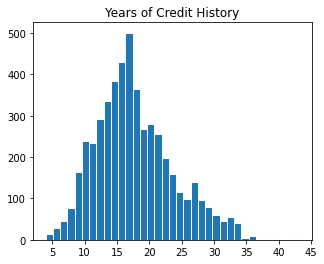

In [17]:
get_hist(X_train, ['Years of Credit History'], bins=35)

Видим, что выбросы все еще присутствуют. Обработаем оставшиеся выбросы функцией *set_num_feature_by_median*.

In [18]:
def set_num_feature_by_median(df, feature, condition,  median_dict, group_feature=None):
    '''Set the values of numerical feature by medians'''
    feature_type = str(df[feature].dtype)
    if 'int' in feature_type or 'float' in feature_type:
        if group_feature is not None:
            if f'{feature}_g-{group_feature}' not in median_dict.keys():
                feature_medians = df.loc[:, [group_feature, feature]].groupby(by=group_feature).median()
                median_dict[f'{feature}_g-{group_feature}'] = feature_medians
            for i in median_dict[f'{feature}_g-{group_feature}'].index:
                current_condition = condition & (df[group_feature] == i)
                df.loc[current_condition, feature] = median_dict[f'{feature}_g-{group_feature}'].loc[i, feature]
        else:
            if f'{feature}' not in median_dict.keys():
                feature_medians = df[feature].median()
                median_dict[f'{feature}'] = feature_medians
            current_condition = condition
            df.loc[current_condition, feature] = median_dict[f'{feature}']    
    else:
        print('Признак должен описываться в числовом формате!')

In [19]:
medians = {}
year_q_993 = X_train['Years of Credit History'].quantile(.993)

for df in df_dict.values():
    max_year_condition = df['Years of Credit History'] > year_q_993
    set_num_feature_by_median(df, 'Years of Credit History',
                              max_year_condition, medians)

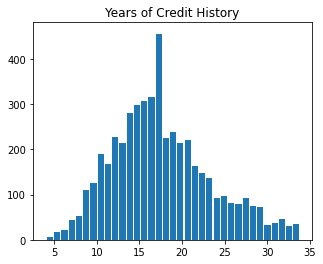

In [20]:
get_hist(X_train, ['Years of Credit History'], bins=35)

Создадим новый признак на основе признака *Years of Credit History*, который будет отражать полные годы кредитной истории - *Years of Credit History floor_rounded*.

In [21]:
def add_rounded_feature(df, feature, orient='floor'):
    if orient == 'floor':
        df[f"{feature} floor_rounded"] = np.floor(df[feature])
        df[f"{feature} floor_rounded"] = df[f"{feature} floor_rounded"].astype(np.uint8)
    elif orient == 'ceil':
        df[f"{feature} ceil_rounded"] = np.ceil(df[feature])
        df[f"{feature} ceil_rounded"] = df[f"{feature} ceil_rounded"].astype(np.uint8)

for df in df_dict.values():
    add_rounded_feature(df, 'Years of Credit History')

**Признак Credit Score**  
Значения данного признака должны находится в диапазоне 300-850.

In [22]:
X_train['Credit Score'].describe()

count    3978.0
mean        inf
std         inf
min       585.0
25%       711.0
50%       731.0
75%       743.0
max      7512.0
Name: Credit Score, dtype: float64

In [23]:
for name, df in df_dict.items():
    count_less_300 = df[df['Credit Score'] < 300].shape[0]
    count_more_850 = df[df['Credit Score'] > 850].shape[0]
    count_na = df[df['Credit Score'].isna()].shape[0]
    print(f"Количество пропусков значений признака Credit Score в {name} равно {count_na}.")
    print(f"Количество значений признака Credit Score выше 850 в {name} равно {count_more_850}.")

Количество пропусков значений признака Credit Score в X_train равно 1047.
Количество значений признака Credit Score выше 850 в X_train равно 269.
Количество пропусков значений признака Credit Score в X_test равно 510.
Количество значений признака Credit Score выше 850 в X_test равно 131.
Количество пропусков значений признака Credit Score в data_test равно 513.
Количество значений признака Credit Score выше 850 в data_test равно 160.


Посмотрим на значения признака *Credit Score*, превышающие значение 850. Построим две гистограммы: первую - для значений до 850 включительно, вторую - для значений более 850.

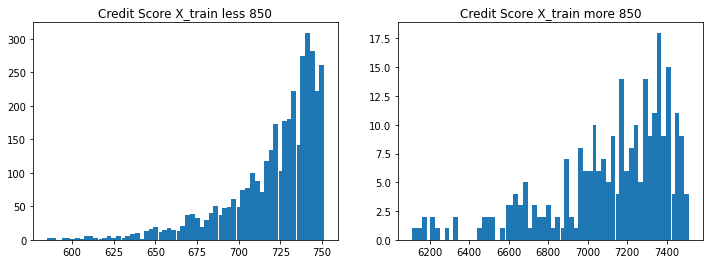

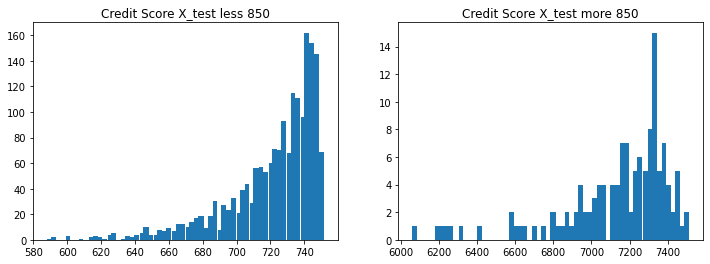

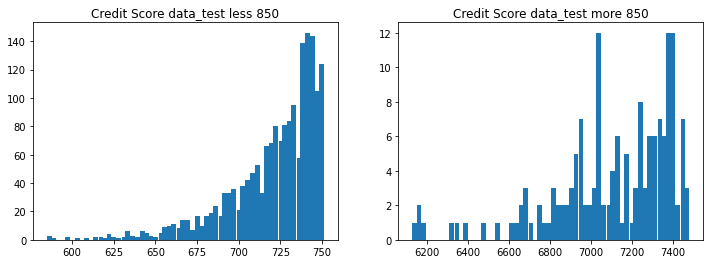

In [24]:
for name, df in df_dict.items():
    df_more_850 = df.loc[df['Credit Score'] > 850, 'Credit Score']
    df_less_850 = df.loc[df['Credit Score'] <= 850, 'Credit Score']

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
    ax1, ax2 = axes
    ax1.hist(df_less_850, bins=60)
    ax1.set_title(f"Credit Score {name} less 850")
    ax2.hist(df_more_850, bins=60)
    ax2.set_title(f"Credit Score {name} more 850")
    plt.show()

Как видим, значения выше 850 повторяют вид рапределения и выше на один порядок значений ниже 850. Все значения данного признака, попадающие под выбросы, разделим на 10.

In [25]:
for name, df in df_dict.items():
    df.loc[df['Credit Score'] > 850, 'Credit Score'] = df.loc[df['Credit Score'] > 850, 'Credit Score'] / 10
    count_more_850 = df[df['Credit Score'] > 850].shape[0]
    print(f"Количество значений признака Credit Score выше 850 в {name} равно {count_more_850}.")

Количество значений признака Credit Score выше 850 в X_train равно 0.
Количество значений признака Credit Score выше 850 в X_test равно 0.
Количество значений признака Credit Score выше 850 в data_test равно 0.


В наборах данных у признака *Credit Score* имеются пропуски. Пропуски заменим случайными значениями данного признака, используя группировку по признаку *Years of Credit History floor_rounded*.

In [26]:
for df in df_dict.values():
    years_unique = df['Years of Credit History floor_rounded'].unique()
    cs_condition = df['Credit Score'].isnull()
    for y in years_unique:
        cur_condition = df['Years of Credit History floor_rounded'] == y
        indexes = df.loc[cur_condition & cs_condition, 'Credit Score'].index
        count_na = df.loc[cur_condition & cs_condition].shape[0]
        df.loc[indexes, ['Credit Score']] = df.loc[cur_condition & ~cs_condition, ['Credit Score']]\
            .sample(n=count_na, random_state=33).values
    df['Credit Score'] = df['Credit Score'].astype(np.uint16)

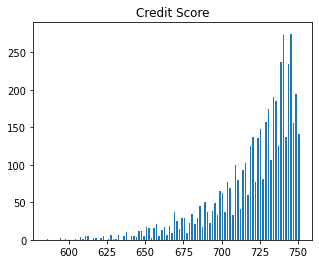

In [27]:
get_hist(X_train, ['Credit Score'], bins=100)

In [28]:
for name, df in df_dict.items():
    count_null = df[df['Credit Score'].isnull()].shape[0]
    print(f"Количество пропусков значений признака Credit Score в {name} равно {count_null}.")

Количество пропусков значений признака Credit Score в X_train равно 0.
Количество пропусков значений признака Credit Score в X_test равно 0.
Количество пропусков значений признака Credit Score в data_test равно 0.


**Признак Years in current job**

In [29]:
X_train['Years in current job'].value_counts()

10+ years    1568
2 years       459
3 years       400
< 1 year      376
5 years       360
1 year        344
6 years       312
4 years       298
7 years       246
8 years       240
9 years       178
Name: Years in current job, dtype: int64

Видим, что значения данного признака можно привести к численному виду. Пропущенные значения заменим значением <code>< 1 year</code>, а затем применим метод *agg* и функцию *find_numbers*.

In [30]:
def find_numbers(x):
    pattern = r'^\d+'
    number_list = re.findall(pattern, x)
    return int(number_list[0]) if number_list else 0

for df in df_dict.values():
    df.loc[df['Years in current job'].isnull() , 'Years in current job'] = '< 1 year'
    df['Years in current job'] = df['Years in current job'].agg(find_numbers).astype(np.uint8)

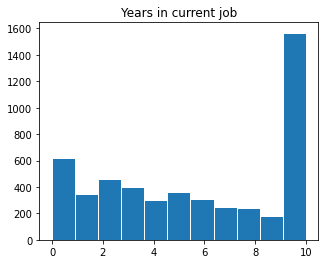

In [31]:
get_hist(X_train, ['Years in current job'], bins=11)

In [32]:
count_less_5 = X_train[X_train['Years in current job'] < 5].shape[0]
count_more_5 = X_train[X_train['Years in current job'] >= 5].shape[0]
print(f'Количество кредиторов, работающих на текущей работе менее 5 лет, равно {count_less_5} (тренировочный набор).')
print(f'Количество кредиторов, работающих на текущей работе более 5 (включительно) лет, равно {count_more_5} (тренировочный набор).')

Количество кредиторов, работающих на текущей работе менее 5 лет, равно 2121 (тренировочный набор).
Количество кредиторов, работающих на текущей работе более 5 (включительно) лет, равно 2904 (тренировочный набор).


Видим, что бОльшая часть кредитующихся работает на текущей работе 5 и более лет.

**Признак Tax Liens**

In [33]:
X_train['Tax Liens'].value_counts()

0    4931
1      60
2      20
3       6
4       5
6       2
5       1
Name: Tax Liens, dtype: int64

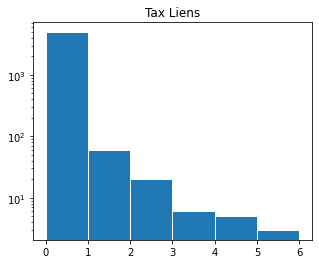

In [34]:
get_hist(X_train, ['Tax Liens'], bins=6, yscale='log')

Значения признака *Tax Liens* аномалий и пропусков не имеют, в обработке не нуждаются.

**Признак Number of Open Accounts**

In [35]:
X_train['Number of Open Accounts'].describe()

count    5025.000000
mean       11.127562
std         4.931119
min         2.000000
25%         8.000000
50%        10.000000
75%        14.000000
max        42.000000
Name: Number of Open Accounts, dtype: float64

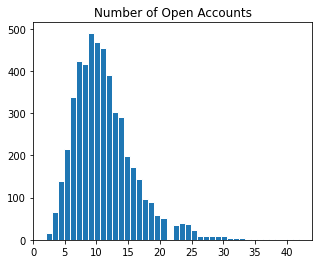

In [36]:
get_hist(X_train, ['Number of Open Accounts'], bins=42)

Форма распределения значений признака похожа на нормальное распределение, имеется длинный правый хвост. Проверим значения на выбросы, построив boxplot.

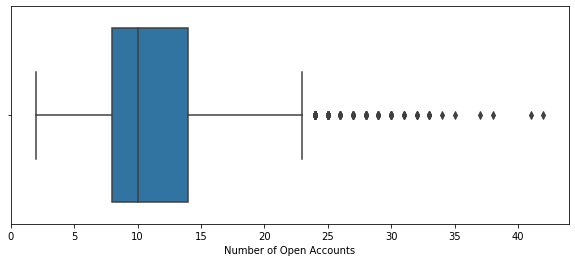

In [37]:
fig, ax = plt.subplots(figsize=(10, 4))
ax = sns.boxplot(x='Number of Open Accounts', data=X_train)
plt.show()

Видим, что превышающие 23 значения признака, являются выбросами. Заменим выбросы медианами, используя группировку по признаку *Years of Credit History floor_rounded*.

In [38]:
for df in df_dict.values():
    num_open_acc_condition = df['Number of Open Accounts'] > 23
    set_num_feature_by_median(df, 'Number of Open Accounts',
                              num_open_acc_condition, medians,
                              group_feature='Years of Credit History floor_rounded')
    df['Number of Open Accounts'] = df['Number of Open Accounts'].astype(np.uint8)

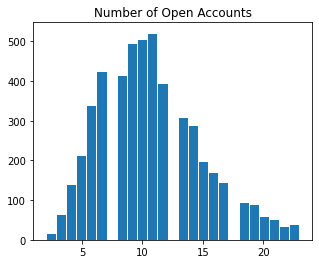

In [39]:
get_hist(X_train, ['Number of Open Accounts'], bins=25)

**Признак Annual Income**

In [40]:
X_train['Annual Income'].describe()

count    3.978000e+03
mean     1.365916e+06
std      8.272425e+05
min      1.645970e+05
25%      8.398902e+05
50%      1.178712e+06
75%      1.639401e+06
max      1.014934e+07
Name: Annual Income, dtype: float64

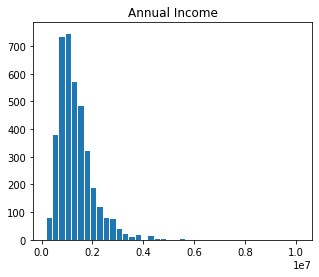

In [41]:
get_hist(X_train, ['Annual Income'], bins=40)

Форма распределения значений признака похожа на нормальное распределение, имеется длинный правый хвост. Проверим значения на выбросы, построив boxplot.

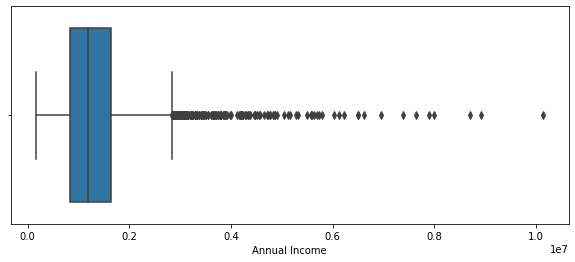

In [42]:
fig, ax = plt.subplots(figsize=(10, 4))
ax = sns.boxplot(x='Annual Income', data=X_train)
plt.show()

Видим довольно большое количество выбросов справа. Найдем правую границу *boxplot* при помощи функции *get_feature_bounds*.

In [43]:
def get_feature_bounds(df, feature):
    f = df[feature].agg([min, q25, q75, max])
    iqr = f['q75'] - f['q25']
    left_bound = f['q25'] - 1.5 * iqr if f['q25'] - 1.5 * iqr > f['min'] else f['min']
    right_bound = f['q75'] + 1.5 * iqr if f['q75'] + 1.5 * iqr < f['max'] else f['max']
    return (left_bound, right_bound)

ai_left_bound, ai_right_bound = get_feature_bounds(X_train, 'Annual Income')
print(f'Правая граница boxplot равна {ai_right_bound}.')

Правая граница boxplot равна 2838666.5.


Заменим пропущенные значения и выбросы на случайные значения данного признака.

In [44]:
for df in df_dict.values():
    ai_null_condition = df['Annual Income'].isnull()
    ai_high_condition = df['Annual Income'] > ai_right_bound
    ai_indexes = df.loc[ai_null_condition | ai_high_condition, 'Annual Income'].index
    ai_count = df.loc[ai_null_condition | ai_high_condition].shape[0]
    df.loc[ai_indexes, ['Annual Income']] = df.loc[~ai_null_condition & ~ai_high_condition, ['Annual Income']]\
        .sample(n=ai_count, random_state=33).values

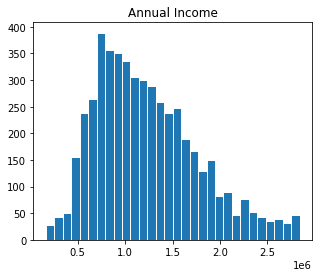

In [45]:
get_hist(X_train, ['Annual Income'], bins=30)

Выделим на основе признака *Annual Income* группы кредиторов по годовому доходу.

In [46]:
ai_groups = {
    'ai_less_0.5_mil': (0, 500000),
    'ai_between_0.5_mil_and_1_mil': (500001, 1000000),
    'ai_between_1_mil_and_1.5_mil': (1000001, 1500000),
    'ai_between_1.5_mil_and_2_mil': (1500001, 2000000),
    'ai_between_2_mil_and_2.5_mil': (2000001, 2500000),
    'ai_more_2.5_mil': (2500001, float('inf'))
}

for df in df_dict.values():
    counter = 0
    df['Annual Income Groups'] = counter
    df['Annual Income Groups'] = df['Annual Income Groups'].astype(np.uint8)
    for grp, grp_values in ai_groups.items():
        counter += 1
        cond = (df['Annual Income'] >= grp_values[0]) & (df['Annual Income'] <= grp_values[1])
        df.loc[cond, 'Annual Income Groups'] = counter

**Признак Maximum Open Credit**

In [47]:
X_train['Maximum Open Credit'].describe()

count    5.025000e+03
mean     1.067820e+06
std      1.955650e+07
min      0.000000e+00
25%      2.812260e+05
50%      4.848140e+05
75%      7.963120e+05
max      1.304726e+09
Name: Maximum Open Credit, dtype: float64

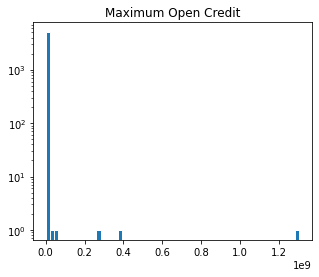

In [48]:
get_hist(X_train, ['Maximum Open Credit'], bins=60, yscale='log')

Видим присутствие явных выбросов в значенях признака. При помощи функции *get_feature_bounds* определим правую границу, за которой начинаются выбросы.

In [49]:
moc_left_bound, moc_right_bound = get_feature_bounds(X_train, 'Maximum Open Credit')
print(f'Правая граница равна {moc_right_bound}.')

Правая граница равна 1568941.0.


Обработаем выбросы при помощи функции *set_num_feature_by_median* с группировкой по новому признаку *Annual Income Groups*.

In [50]:
for df in df_dict.values():
    moc_high_condition = df['Maximum Open Credit'] > moc_right_bound
    set_num_feature_by_median(df, 'Maximum Open Credit',
                              moc_high_condition, medians, group_feature='Annual Income Groups')

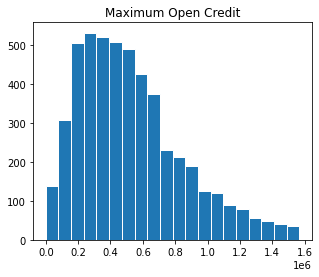

In [51]:
get_hist(X_train, ['Maximum Open Credit'], bins=20)

**Признак Number of Credit Problems**

In [52]:
X_train['Number of Credit Problems'].value_counts()

0    4350
1     575
2      69
3      18
5       7
6       3
4       3
Name: Number of Credit Problems, dtype: int64

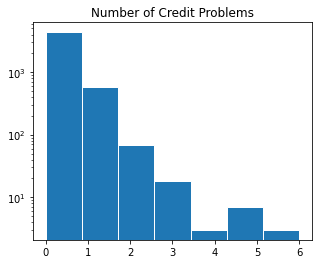

In [53]:
get_hist(X_train, ['Number of Credit Problems'], bins=7,yscale='log')

Значения признака *Number of Credit Problems* аномалий и пропусков не имеют, в обработке не нуждаются.

**Признак Months since last delinquent**

In [54]:
X_train['Months since last delinquent'].describe()

count    2288.00000
mean            inf
std        21.53125
min         0.00000
25%        17.00000
50%        32.00000
75%        50.00000
max       118.00000
Name: Months since last delinquent, dtype: float64

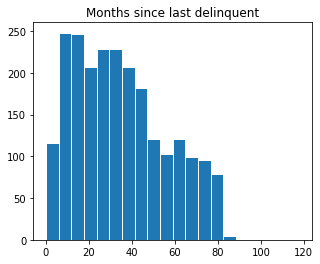

In [55]:
get_hist(X_train, ['Months since last delinquent'])

В значениях признака имеется много пропусков. Скорее всего, данные по данному признаку отсутствуют у кредиторов, которые не имели ни разу просрочек по платежам. Поэтому заменим пропуски на число 600 (50 лет х 12 месяцев).

In [56]:
for df in df_dict.values():
    df.loc[df['Months since last delinquent'].isnull(), 'Months since last delinquent'] = 600
    df['Months since last delinquent'] = df['Months since last delinquent'].astype(np.uint16)

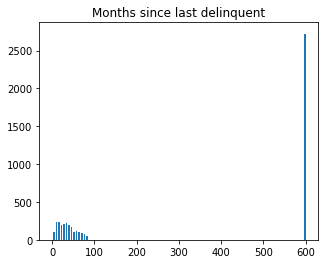

In [57]:
get_hist(X_train, ['Months since last delinquent'], bins=100)

**Признак Bankruptcies**

In [58]:
X_train['Bankruptcies'].value_counts()

0.0    4478
1.0     515
2.0      21
3.0       1
Name: Bankruptcies, dtype: int64

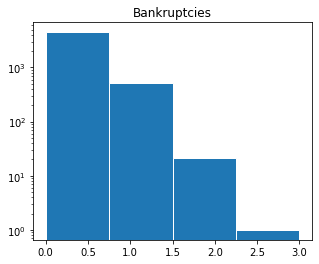

In [59]:
get_hist(X_train, ['Bankruptcies'], bins=4, yscale='log')

Аномалий в форме распределения значений признака нет, есть некоторое количество пропусков, которые заменим на нуль.

In [60]:
for df in df_dict.values():
    df.loc[df['Bankruptcies'].isnull(), 'Bankruptcies'] = 0
    df['Bankruptcies'] = df['Bankruptcies'].astype(np.uint8)

**Признак Current Loan Amount**

In [61]:
X_train['Current Loan Amount'].describe()

count    5.025000e+03
mean     1.199689e+07
std      3.207078e+07
min      2.147200e+04
25%      1.817200e+05
50%      3.124000e+05
75%      5.295180e+05
max      1.000000e+08
Name: Current Loan Amount, dtype: float64

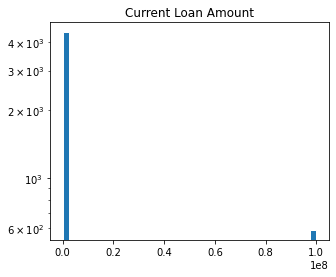

In [62]:
get_hist(X_train, ['Current Loan Amount'], bins=40, yscale='log')

Обнаруживаем наличие явных выбросов. Посмотрим правую границу, за которой начинаются выбросы.

In [63]:
cla_left_bound, cla_right_bound = get_feature_bounds(X_train, 'Current Loan Amount')
print(f"Правая граница равна {cla_right_bound}.")
count_cla_outliers = X_train[X_train['Current Loan Amount'] > cla_right_bound].shape[0]
print(f"Количество выбросов в X_train равно {count_cla_outliers}.")

Правая граница равна 1051215.0.
Количество выбросов в X_train равно 589.


In [64]:
cla_ind = X_train[X_train['Current Loan Amount'] > cla_right_bound].index
X_train.loc[cla_ind, ['Maximum Open Credit', 'Current Loan Amount', 'Annual Income']].head()

,Maximum Open Credit,Current Loan Amount,Annual Income
3802,328064,99999999,1008748.0
2926,516142,99999999,852777.0
1774,444466,99999999,1872830.0
487,273196,99999999,541101.0
4811,404250,99999999,1938190.0


Обработаем выбросы при помощи функции *set_num_feature_by_median* с группировкой по новому признаку *Annual Income Groups*.

In [65]:
for df in df_dict.values():
    cla_high_condition = df['Current Loan Amount'] > cla_right_bound
    set_num_feature_by_median(df, 'Current Loan Amount',
                              cla_high_condition, medians, group_feature='Annual Income Groups')

In [66]:
X_train.loc[cla_ind, ['Maximum Open Credit', 'Current Loan Amount', 'Annual Income']].head()

,Maximum Open Credit,Current Loan Amount,Annual Income
3802,328064,332365,1008748.0
2926,516142,239778,852777.0
1774,444466,392194,1872830.0
487,273196,239778,541101.0
4811,404250,392194,1938190.0


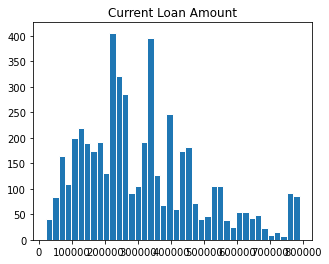

In [67]:
get_hist(X_train, ['Current Loan Amount'], bins=40)

**Признак Current Credit Balance**

In [68]:
X_train['Current Credit Balance'].describe()

count    5.025000e+03
mean     2.912397e+05
std      3.222598e+05
min      0.000000e+00
25%      1.142660e+05
50%      2.108620e+05
75%      3.627290e+05
max      6.506797e+06
Name: Current Credit Balance, dtype: float64

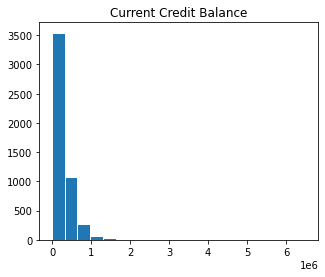

In [69]:
get_hist(X_train, ['Current Credit Balance'])

In [70]:
ccb_left_bound, ccb_right_bound = get_feature_bounds(X_train, 'Current Credit Balance')
print(f'Правая граница равна {ccb_right_bound}.')
count_ccb_outliers = X_train[X_train['Current Credit Balance'] > ccb_right_bound].shape[0]
print(f"Количество выбросов в X_train равно {count_ccb_outliers}.")

Правая граница равна 735423.5.
Количество выбросов в X_train равно 286.


In [71]:
for df in df_dict.values():
    ccb_high_condition = df['Current Credit Balance'] > ccb_right_bound
    set_num_feature_by_median(df, 'Current Credit Balance',
                              ccb_high_condition, medians,
                              group_feature='Annual Income Groups')

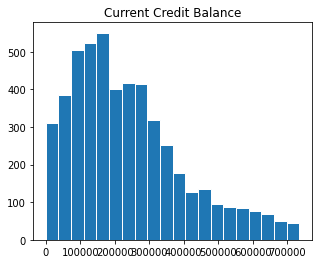

In [72]:
get_hist(X_train, ['Current Credit Balance'])

**Признак Monthly Debt**

In [73]:
X_train['Monthly Debt'].describe()

count      5025.000000
mean      18375.313831
std       12099.295466
min           0.000000
25%       10020.000000
50%       16075.000000
75%       23901.000000
max      136679.000000
Name: Monthly Debt, dtype: float64

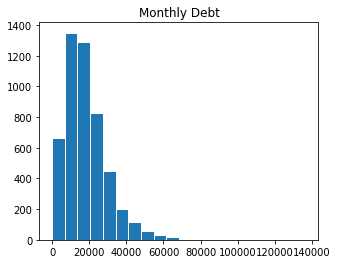

In [74]:
get_hist(X_train, ['Monthly Debt'])

In [75]:
md_left_bound, md_right_bound = get_feature_bounds(X_train, 'Monthly Debt')
print(f'Правая граница равна {md_right_bound}.')
count_md_outliers = X_train[X_train['Monthly Debt'] > md_right_bound].shape[0]
print(f"Количество выбросов в X_train равно {count_md_outliers}.")

Правая граница равна 44722.5.
Количество выбросов в X_train равно 177.


In [76]:
for df in df_dict.values():
    md_high_condition = df['Monthly Debt'] > md_right_bound
    set_num_feature_by_median(df, 'Monthly Debt',
                              md_high_condition, medians,
                              group_feature='Annual Income Groups')

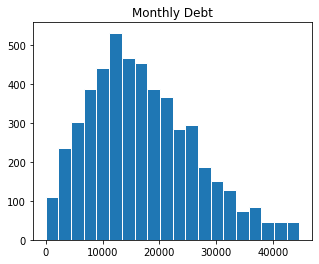

In [77]:
get_hist(X_train, ['Monthly Debt'])

**Признак Home Ownership**

In [78]:
X_train['Home Ownership'].value_counts()

Home Mortgage    2467
Rent             2099
Own Home          450
Have Mortgage       9
Name: Home Ownership, dtype: int64

Видим, что есть дублирующая категория *Have Mortgage*, в которой всего 9 записей. Переведем такие записи в категорию *Home Mortgage*.

In [79]:
for df in df_dict.values():
    ho_condition = df['Home Ownership'] == 'Have Mortgage'
    df.loc[ho_condition, 'Home Ownership'] = 'Home Mortgage'
    df['Home Ownership'] = df['Home Ownership'].cat.remove_unused_categories()

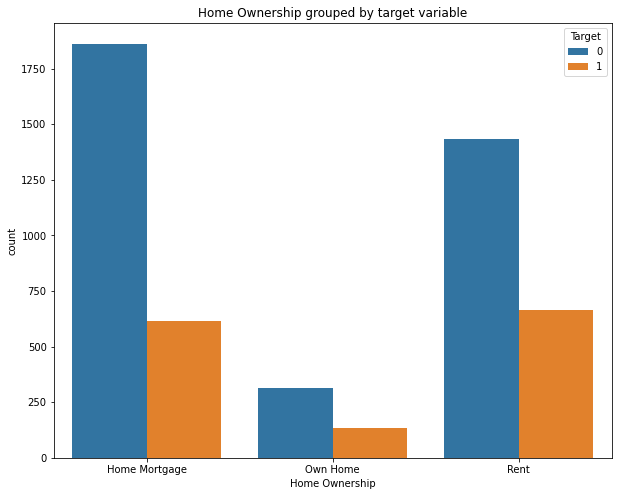

In [80]:
plt.figure(figsize=(10, 8))

sns.countplot(x='Home Ownership', hue=y_train, data=X_train)
plt.title('Home Ownership grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

**Наблюдение**  
Изучив получившийся график, видно, что значения **Home Mortgage (дом в ипотеку)**, **Own Home (собственный дом)** и **Rent (аренда)** признака *Home Ownership* имеют схожие доли в разрезе целевой переменной. Если это действительно так, то можно будет не учитывать этот признак при построении модели (если все категории будут попарно согласованы) или объединить пары в одну категорию (если будут согласованы определенные пары категорий).  
**Гипотеза**
* Нулевая гипотеза: ожидаемые и наблюдаемые частоты согласованы.
* Альтернативная гипотеза: отклонения в частотах выходят за рамки случайных колебаний, расхождения статистически значимы.
* Критерий: Хи-квадрат Пирсона.
* Уровень значимости α: 0.05.
* Критическая область: двухсторонняя.

Для проверки данной гипотезы необходимо попарно подать наблюдаемые частоты категорий **Home Mortgage**, **Own Home** и **Rent** признака *Home Ownership* в выбранный критерий, после чего оценить значение достигаемого уровня значимости p-value и сравнить его с выбранным порогом альфа, если p-value получится больше выбранного порога, то гипотезу о согласованности частот можно не отбрасывать.

Так как набор данных невелик, то используем все записи X_train для расчета наблюдаемых частот.

In [81]:
def check_chi2(df, target, feature, pair, add_feature):
    cur_df = df[[feature, add_feature]].join(target)
    table = cur_df.loc[cur_df[feature].isin(pair)].pivot_table(values=add_feature, index=feature,
                                                               columns=target, aggfunc='count')
    chi2, p, dof, expected = chi2_contingency(table, correction=False)
    return p

In [82]:
pairs = [list(x) for x in itertools.combinations(X_train['Home Ownership'].unique(), 2)]
for pair in pairs:
    p = check_chi2(X_train, y_train, 'Home Ownership', pair, 'Credit Score')
    print(f'Значение p-value между категориями {pair[0]} и {pair[1]} равно {round(p, 3)}.')

Значение p-value между категориями Home Mortgage и Rent равно 0.0.
Значение p-value между категориями Home Mortgage и Own Home равно 0.015.
Значение p-value между категориями Rent и Own Home равно 0.558.


P-value между **Rent** и **Own Home** получилось больше выбранного уровня значимости, соответственно у нас нет оснований для отвержения нулевой гипотезы и можно допустить, что категории **Rent** и **Own Home** одинаково влияют на целевую переменную и их можно объединить в одну категорию.

Так как в данном признаке можно выделить 2 категории, то закодируем его:
* **Rent** и **Own Home** - 0,
* **Home Mortgage** - 1.

In [83]:
for df in df_dict.values():
    df.replace({'Home Ownership': {'Rent': 0, 'Own Home': 0, 'Home Mortgage': 1}}, inplace=True)
    df['Home Ownership'] = df['Home Ownership'].astype(np.uint8)

In [84]:
X_train['Home Ownership'].value_counts()

0    2549
1    2476
Name: Home Ownership, dtype: int64

**Признак Term**

In [85]:
X_train['Term'].value_counts()

Short Term    3710
Long Term     1315
Name: Term, dtype: int64

В данном категориальном признаке всего два уникальных значения, поэтому закодируем его:
* **Short Term** - 0,
* **Long Term** - 1.

In [86]:
for df in df_dict.values():
    df.replace({'Term': {'Short Term': 0, 'Long Term': 1}}, inplace=True)
    df['Term'] = df['Term'].astype(np.uint8)

Построим Q-Q графики и сделаем вывод о характере распределений признаков в наборах данных.

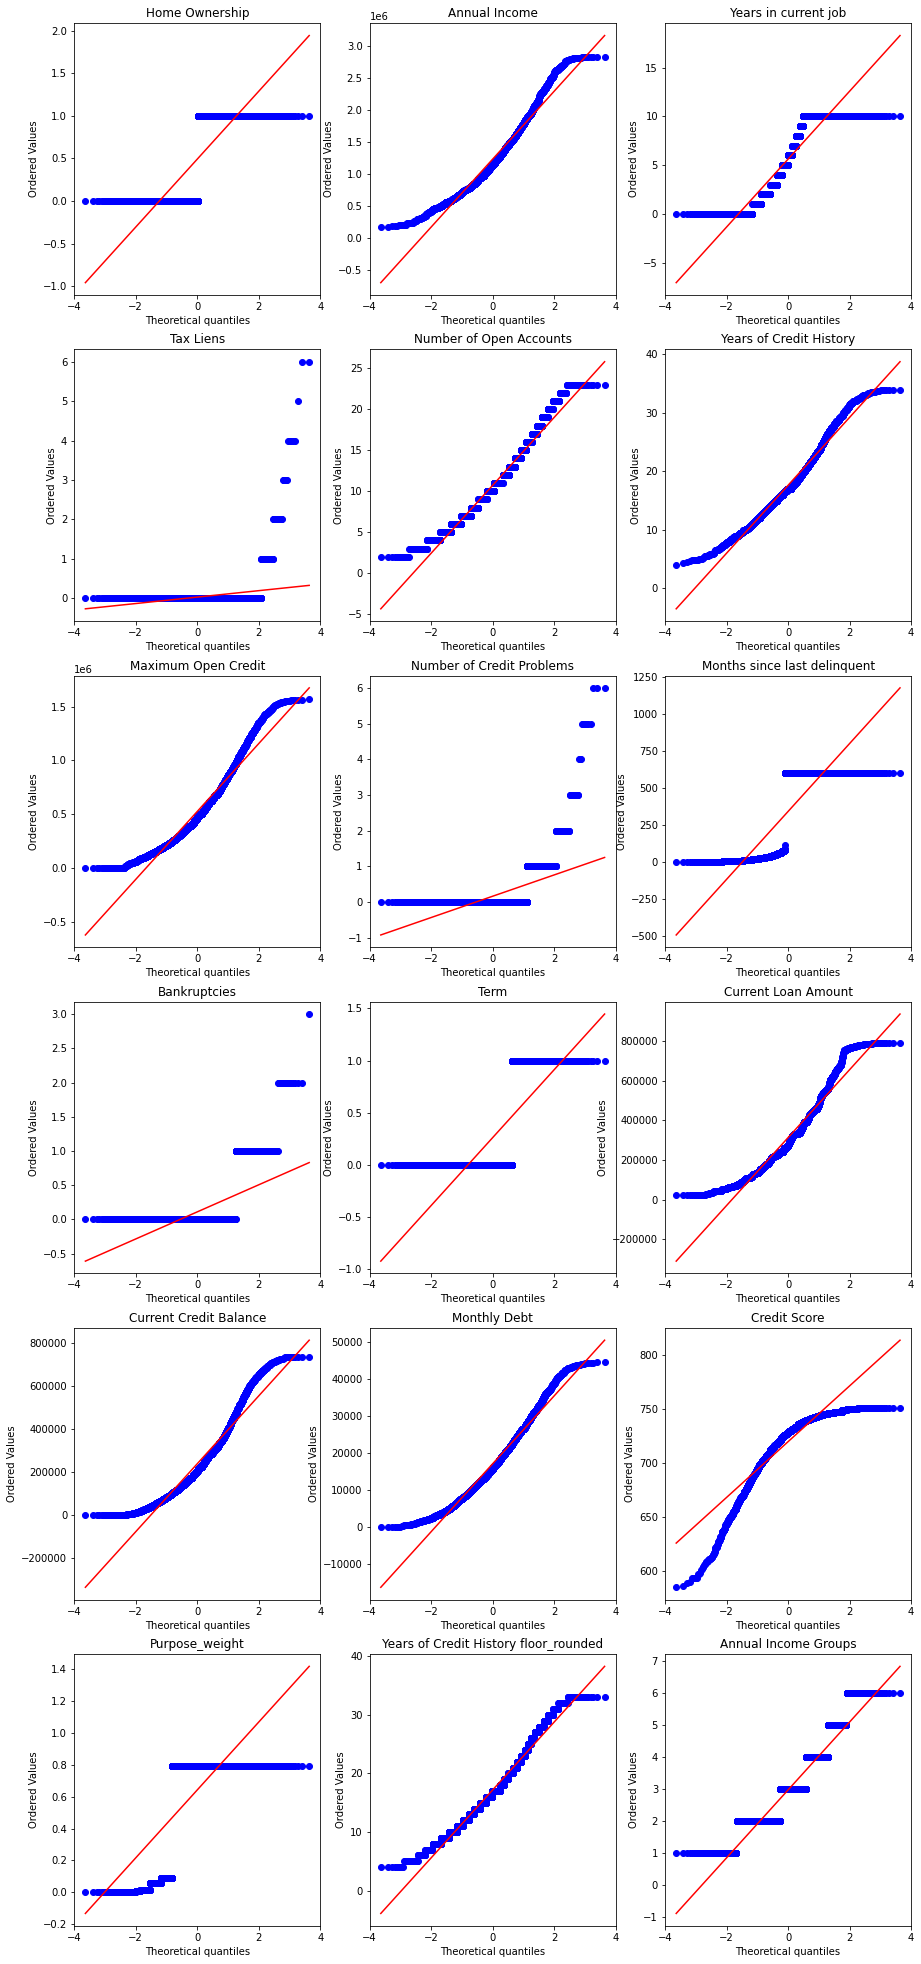

In [87]:
feature_list = list(X_train.select_dtypes(exclude='category').columns)
fig, axes = plt.subplots(nrows=len(feature_list)//3, ncols=3, figsize=(15, 35))
for ax, f in zip(axes.reshape(-1), feature_list):
    probplot(X_train[f], dist='norm', plot=ax)
    ax.set_title(f)
plt.show()

Видим, что ни один из признаков не имеет нормального распределения.

### **Отбор признаков**

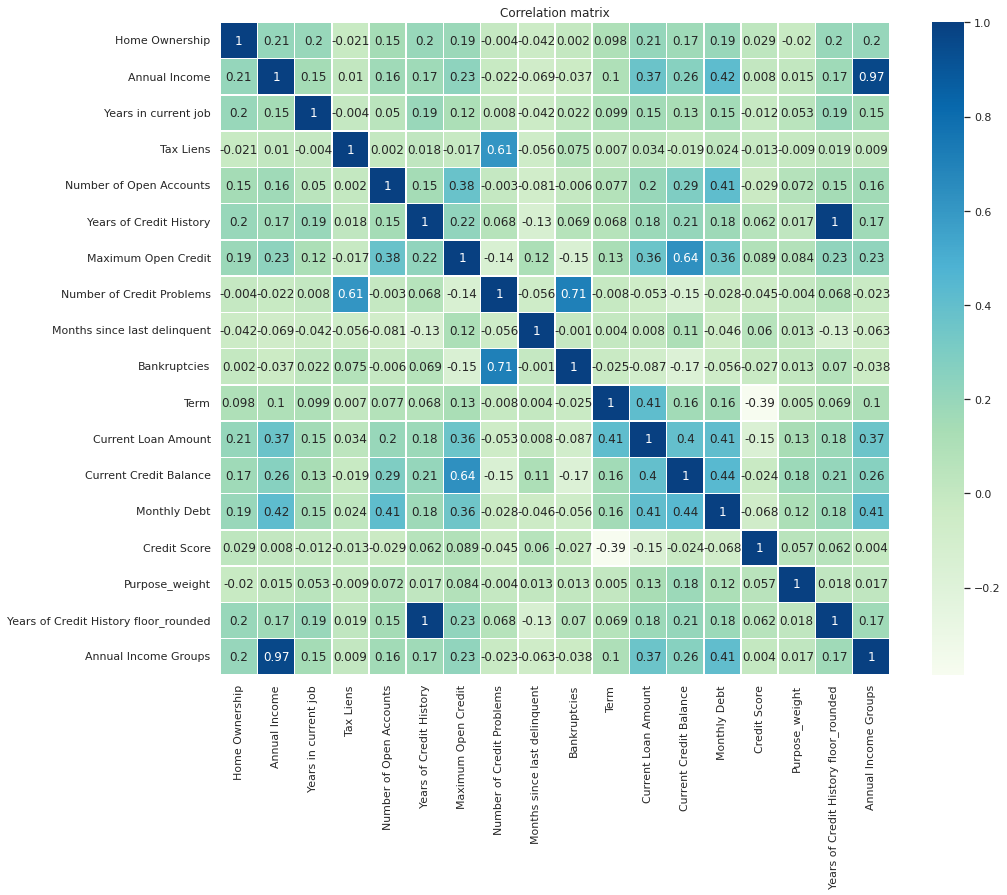

In [88]:
plt.figure(figsize = (15, 12))

sns.set(font_scale=1.0)
sns.heatmap(X_train[feature_list].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

Видим, что признак *Number of Credit Problems* довольно хорошо коррелирует с признаками *Tax Liens* (0.61) и *Bankruptcies* (0.71), а признак *Current Credit Balance* с признаком *Maximum Open Credit* (0.64).

**Корреляция признаков с целевой переменной**

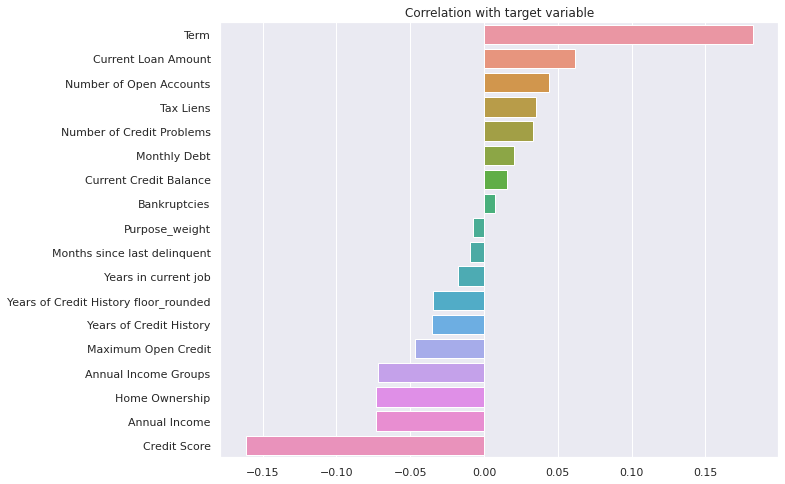

In [89]:
corr_with_target = pd.concat([X_train, y_train], axis=1).corr().iloc[:-1, -1].sort_values(ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Correlation with target variable')
plt.show()

Ни один из признаков сильно не коррелирует с целевой переменной.

In [90]:
selected_features = ['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit',
       'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies',
       'Term', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Purpose_weight']

In [91]:
df_dict_selected = {}

for k in df_dict.keys():
    df_dict_selected[f'{k}_selected'] = df_dict[k][selected_features]

In [92]:
X_train_selected = df_dict_selected['X_train_selected']
X_test_selected = df_dict_selected['X_test_selected']
data_test_selected = df_dict_selected['data_test_selected']

### **Балансировка классов**

Так как среди данных целевой переменной наблюдается дисбаланс классов (преобладает класс 0), то для обучения модели необходимо сбалансировать классы.

In [93]:
y_train.value_counts()

0    3611
1    1414
Name: Credit Default, dtype: int64

In [94]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    delta = target_counts[major_class_name] - target_counts[minor_class_name]

    sample = df[df[target_name] == minor_class_name].sample(delta, replace=True, random_state=39)
    df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [95]:
df_for_balancing = pd.concat([X_train_selected, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, target)
    
df_balanced[target].value_counts()

1    3611
0    3611
Name: Credit Default, dtype: int64

In [96]:
X_train_balanced = df_balanced.drop(columns=target)
y_train_balanced = df_balanced[target]

In [97]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train_balanced.copy())
X_test_scaled = scaler.transform(X_test_selected.copy())
data_test_scaled = scaler.transform(data_test_selected.copy())

### **Подбор модели**

In [98]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

**Логистическая регрессия**

In [99]:
lr_model = LogisticRegression(random_state=13)
lr_model.fit(X_train_scaled, y_train_balanced)

y_train_lr_pred = lr_model.predict(X_train_scaled)
y_test_lr_pred = lr_model.predict(X_test_scaled)

get_classification_report(y_train_balanced, y_train_lr_pred, y_test, y_test_lr_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.61      0.65      0.63      3611
           1       0.62      0.58      0.60      3611

    accuracy                           0.61      7222
   macro avg       0.61      0.61      0.61      7222
weighted avg       0.61      0.61      0.61      7222

TEST

              precision    recall  f1-score   support

           0       0.79      0.64      0.71      1776
           1       0.39      0.57      0.46       699

    accuracy                           0.62      2475
   macro avg       0.59      0.61      0.58      2475
weighted avg       0.68      0.62      0.64      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1137  639
1                298  401


**Модель XGBoost**

In [100]:
xgb_model = xgb.XGBClassifier(random_state=13)
xgb_model.fit(X_train_scaled, y_train_balanced)

y_train_xgb_pred = xgb_model.predict(X_train_scaled)
y_test_xgb_pred = xgb_model.predict(X_test_scaled)

get_classification_report(y_train_balanced, y_train_xgb_pred, y_test, y_test_xgb_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.73      0.69      0.71      3611
           1       0.71      0.75      0.73      3611

    accuracy                           0.72      7222
   macro avg       0.72      0.72      0.72      7222
weighted avg       0.72      0.72      0.72      7222

TEST

              precision    recall  f1-score   support

           0       0.81      0.65      0.72      1776
           1       0.41      0.62      0.49       699

    accuracy                           0.64      2475
   macro avg       0.61      0.63      0.61      2475
weighted avg       0.70      0.64      0.66      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1152  624
1                267  432


**Модель LightGBM**

In [101]:
lgbm_model = lgbm.LGBMClassifier(random_state=13)
lgbm_model.fit(X_train_scaled, y_train_balanced)

y_train_lgbm_pred = lgbm_model.predict(X_train_scaled)
y_test_lgbm_pred = lgbm_model.predict(X_test_scaled)

get_classification_report(y_train_balanced, y_train_lgbm_pred, y_test, y_test_lgbm_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.94      0.90      0.92      3611
           1       0.91      0.94      0.92      3611

    accuracy                           0.92      7222
   macro avg       0.92      0.92      0.92      7222
weighted avg       0.92      0.92      0.92      7222

TEST

              precision    recall  f1-score   support

           0       0.77      0.74      0.76      1776
           1       0.40      0.43      0.42       699

    accuracy                           0.65      2475
   macro avg       0.58      0.59      0.59      2475
weighted avg       0.66      0.65      0.66      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1317  459
1                395  304


**Модель CatBoost**

In [102]:
catb_model = catb.CatBoostClassifier(eval_metric='TotalF1', silent=True, random_state=13)
catb_model.fit(X_train_scaled, y_train_balanced)

y_train_catb_pred = catb_model.predict(X_train_scaled)
y_test_catb_pred = catb_model.predict(X_test_scaled)

get_classification_report(y_train_balanced, y_train_catb_pred, y_test, y_test_catb_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.93      0.89      0.91      3611
           1       0.89      0.93      0.91      3611

    accuracy                           0.91      7222
   macro avg       0.91      0.91      0.91      7222
weighted avg       0.91      0.91      0.91      7222

TEST

              precision    recall  f1-score   support

           0       0.78      0.75      0.76      1776
           1       0.42      0.46      0.44       699

    accuracy                           0.67      2475
   macro avg       0.60      0.61      0.60      2475
weighted avg       0.68      0.67      0.67      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1329  447
1                374  325


Из всех построенных выше моделей самой лучшей с параметрами по умолчанию оказалась модель XGBoost (f1 для класса 1 равна 0,49). Возмем эту модель для дальнейшей работы, подберем для нее гиперпараметры.

### **Выбор гиперпараметров**

In [103]:
cv=KFold(n_splits=3, random_state=13, shuffle=True)

params = {'n_estimators': [50, 100, 150, 200, 500],
          'max_depth': [2, 3, 4, 6, 10],
          'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.5],
          'min_child_weight': [3, 4, 5, 6, 10],
          'subsample': [0.7, 0.8, 0.85, 0.9, 0.95],
          'colsample_bytree': [0.4, 0.45, 0.53, 0.6, 0.8]}

rs = RandomizedSearchCV(xgb.XGBClassifier(random_state=13), params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X_train_scaled, y_train_balanced)

RandomizedSearchCV(cv=KFold(n_splits=3, random_state=13, shuffle=True),
                   estimator=XGBClassifier(random_state=13), n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.4, 0.45, 0.53,
                                                             0.6, 0.8],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.5],
                                        'max_depth': [2, 3, 4, 6, 10],
                                        'min_child_weight': [3, 4, 5, 6, 10],
                                        'n_estimators': [50, 100, 150, 200,
                                                         500],
                                        'subsample': [0.7, 0.8, 0.85, 0.9,
                                                      0.95]},
                   scoring='f1')

In [104]:
params_list = [f'{k}: {v}' for k, v in rs.best_params_.items()]
print(f'Лучшее значение метрики равно {round(rs.best_score_, 4)} при следующих параметрах:', *params_list, sep='\n--> ')

Лучшее значение метрики равно 0.8264 при следующих параметрах:
--> subsample: 0.95
--> n_estimators: 200
--> min_child_weight: 5
--> max_depth: 10
--> learning_rate: 0.2
--> colsample_bytree: 0.6


Так как для нас важно максимизировать долю правильно предсказанных дефолтов по платежам, то лучшее значение метрики достигается при следующих параметрах:
* max_depth: 3
* learning_rate: 0.1
* subsample: 0.95
* n_estimators: 100
* min_child_weight: 5
* colsample_bytree: 0.53

In [105]:
final_model = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=3,
                              min_child_weight=5, subsample=0.95, 
                              colsample_bytree=0.53, random_state=13)
final_model.fit(X_train_scaled, y_train_balanced)

y_train_final_pred = final_model.predict(X_train_scaled)
y_test_final_pred = final_model.predict(X_test_scaled)

get_classification_report(y_train_balanced, y_train_final_pred, y_test, y_test_final_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.73      0.69      0.71      3611
           1       0.71      0.74      0.72      3611

    accuracy                           0.72      7222
   macro avg       0.72      0.72      0.72      7222
weighted avg       0.72      0.72      0.72      7222

TEST

              precision    recall  f1-score   support

           0       0.82      0.65      0.73      1776
           1       0.42      0.64      0.51       699

    accuracy                           0.65      2475
   macro avg       0.62      0.65      0.62      2475
weighted avg       0.71      0.65      0.67      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1163  613
1                254  445


**Предсказание на наборе данных data_test**

In [106]:
data_test_pred = pd.DataFrame(final_model.predict(data_test_scaled), columns=[target])
df_pred = data_test_pred.reset_index()
df_pred.columns = ['Id', target]
df_pred.to_csv('RMirskov_pred.csv', index=False)

In [107]:
df_pred.shape

(2500, 2)